<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# A Baseline Model for the Radiant Earth Spot the Crop Challenge

This notebook walks you through the steps to load the data and build a baseline model using Random Forests for `Radiant Earth Spot the Crop Challenge`.

## Radiant MLHub API


The Radiant MLHub API gives access to open Earth imagery training data for machine learning applications. You can learn more about the repository at the [Radiant MLHub site](https://mlhub.earth) and about the organization behind it at the [Radiant Earth Foundation site](https://radiant.earth).

Full documentation for the API is available at [docs.mlhub.earth](docs.mlhub.earth).

Each item in our collection is explained in json format compliant with [STAC](https://stacspec.org/) [label extension](https://github.com/radiantearth/stac-spec/tree/master/extensions/label) definition.

## Dependencies

All the dependencies for this notebook are included in the `requirements.txt` file included in this folder.


**You must replace the `YOUR_API_KEY_HERE` text with your API key which you can obtain by creating a free account on the [MLHub Dashboard](https://dashboard.mlhub.earth/) within the `API Keys` tab at the top of the page.**

In [ ]:
from radiant_mlhub import Collection
import tarfile
import os
from pathlib import Path
import json

import datetime
import rasterio
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
b04_src = rasterio.open("C:\\Users\\USER\\Desktop\\fo\\3_B04_20190606.tif")
b04_array = np.expand_dims(b04_src.read(1).flatten(), axis=1)
b04_array.shape

(6118560, 1)

In [3]:
b8a_src = rasterio.open("C:\\Users\\USER\\Desktop\\fo\\3_B8A_20190701.tif")
b8a_array = np.expand_dims(b8a_src.read(1).flatten(), axis=1)
b8a_array

array([[0.3529],
       [0.3529],
       [0.3137],
       ...,
       [0.3466],
       [0.334 ],
       [0.334 ]], dtype=float32)

In [4]:
X_tile = np.empty((6118560, 0)) #256 * 256
X_tile.shape

(6118560, 0)

In [5]:
X_tile = np.append(X_tile, b04_array, axis = 1)
X_tile = np.append(X_tile, b8a_array, axis = 1)
X_tile.shape

(6118560, 2)

In [6]:
X = np.empty((0, 2))
X.shape
X = np.append(X, X_tile, axis=0)

In [7]:
data = pd.DataFrame(X)
#data['label'] = y.astype(int)
#data['field_id'] = field_ids
#data = data[data.field_id != 0]
data

,0,1
0,0.0910,0.3529
1,0.0927,0.3529
2,0.0937,0.3137
3,0.0938,0.3137
4,0.0965,0.3186
...,...,...
6118555,0.0637,0.3158
6118556,0.0673,0.3466
6118557,0.0690,0.3466
6118558,0.0711,0.3340


In [8]:
n_obs=1
#data[ : 4 * n_obs : n_obs]
data[:3*5:3]

,0,1
0,0.0910,0.3529
3,0.0938,0.3137
6,0.0993,0.3236
9,0.1248,0.2848
12,0.0944,0.2934


In [9]:
b8a_src.read(1)

array([[0.3529, 0.3529, 0.3137, ..., 0.4552, 0.4039, 0.4039],
       [0.3529, 0.3529, 0.3137, ..., 0.4552, 0.4039, 0.4039],
       [0.3474, 0.3474, 0.3271, ..., 0.4263, 0.4121, 0.4121],
       ...,
       [0.4273, 0.4273, 0.359 , ..., 0.3428, 0.3318, 0.3318],
       [0.4273, 0.4273, 0.359 , ..., 0.3428, 0.3318, 0.3318],
       [0.3919, 0.3919, 0.3797, ..., 0.3466, 0.334 , 0.334 ]],
      dtype=float32)

(6118560,)


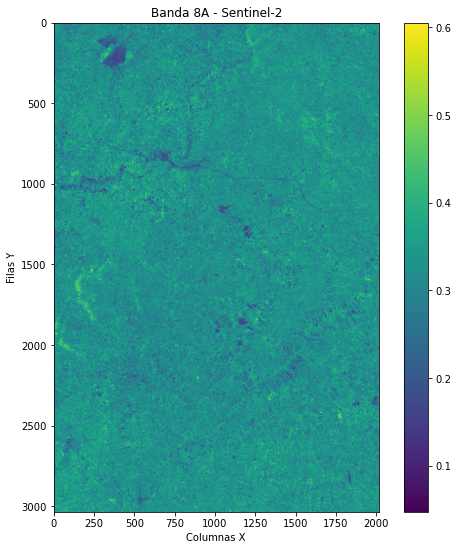

In [10]:
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.plot import show

print(b8a_src.read(1).flatten().shape)
plt.figure(figsize=(9,9))
plt.imshow(b8a_src.read(1), cmap="viridis") # magma, gray, etc.
plt.colorbar()
plt.title("Banda 8A - Sentinel-2") # Titulo
plt.xlabel('Columnas X') # Nombre del eje X
plt.ylabel('Filas Y') # Nombre del eje Y
plt.show()

In [29]:
data_copy = data[:3*5:3]
data_copy = data_copy.reset_index()
data_copy['Test']=np.nan
data_copy.loc[2,'Test']=23
data_copy['index']=[1,1,2,2,3]
data_grouped = data_copy.groupby('index').mean().reset_index()
data_grouped

,index,0,1,Test
0,1,0.09240,0.3333,NaN
1,2,0.11205,0.3042,23.0
2,3,0.09440,0.2934,NaN


## Downloading and Loading the Data

In this part, we will download the data from Radiant MLHub and load the properties of each item in the dataset into a DataFrame


In [ ]:
os.environ['MLHUB_API_KEY'] = 'YOUR_API_KEY_HERE'

collections = [
    'ref_south_africa_crops_competition_v1_train_labels',
    'ref_south_africa_crops_competition_v1_train_source_s1', 
    'ref_south_africa_crops_competition_v1_test_labels',
    'ref_south_africa_crops_competition_v1_test_source_s1', 
#     'ref_south_africa_crops_competition_v1_test_source_s2' # Uncomment this out if you want to download the Sentinel-2 Data (not needed for the Hackathon)
#     'ref_south_africa_crops_competition_v1_train_source_s2', # Uncomment this out if you want to download the Sentinel-2 Data (not needed for the Hackathon)

]

def download(collection_id):
    print(f'Downloading {collection_id}...')
    collection = Collection.fetch(collection_id)
    path = collection.download('.')
    path = collection_id + '.tar.gz'
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(path)
    
def resolve_path(base, path):
    return Path(os.path.join(base, path)).resolve()
    
def load_df(collection_id):
    collection = json.load(open(f'{collection_id}/collection.json', 'r'))
    rows = []
    item_links = []
    for link in collection['links']:
        if link['rel'] != 'item':
            continue
        item_links.append(link['href'])
        
    for item_link in item_links:
        item_path = f'{collection_id}/{item_link}'
        current_path = os.path.dirname(item_path)
        item = json.load(open(item_path, 'r'))
        tile_id = item['id'].split('_')[-1]
        for asset_key, asset in item['assets'].items():
            rows.append([
                tile_id,
                None,
                None,
                asset_key,
                str(resolve_path(current_path, asset['href']))
            ])
            
        for link in item['links']:
            if link['rel'] != 'source':
                continue
            link_path = resolve_path(current_path, link['href'])
            source_path = os.path.dirname(link_path)
            try:
                source_item = json.load(open(link_path, 'r'))
            except FileNotFoundError:
                continue
            datetime = source_item['properties']['datetime']
            satellite_platform = source_item['collection'].split('_')[-1]
            for asset_key, asset in source_item['assets'].items():
                rows.append([
                    tile_id,
                    datetime,
                    satellite_platform,
                    asset_key,
                    str(resolve_path(source_path, asset['href']))
                ])
    return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

# for c in collections:
#     download(c)

#competition_train_df = load_df('ref_south_africa_crops_competition_v1_train_labels')
#competition_test_df = load_df('ref_south_africa_crops_competition_v1_test_labels')

In [ ]:
competition_train_df

In [ ]:
# This DataFrame lists all types of assets including documentation of the data. 
# In the following, we will use the Sentinel-1 bands (VV and VH) as well as labels. 
competition_train_df['asset'].unique()

In [ ]:
tile_ids_train = competition_train_df['tile_id'].unique()

In [ ]:
# For simplicty of this baseline model, we will use only 5 observations throughout the growing season
# You can choose to use all of them, select a few of them at specifc intervals, or 
# load as many as you want and interpolate between them to have a regular temporal frequency.
n_obs = 5

In [ ]:
X = np.empty((0, 2 * (n_obs-1)))
y = np.empty((0, 1))
field_ids = np.empty((0, 1))

for tile_id in tile_ids_train:
    if tile_id != '1951': # avoid using this specific tile for the Hackathon as it might have a missing file
        
        tile_df = competition_train_df[competition_train_df['tile_id']==tile_id]

        label_src = rasterio.open(tile_df[tile_df['asset']=='labels']['file_path'].values[0])
        label_array = label_src.read(1)
        y = np.append(y, label_array.flatten())

        field_id_src = rasterio.open(tile_df[tile_df['asset']=='field_ids']['file_path'].values[0])
        field_id_array = field_id_src.read(1)
        field_ids = np.append(field_ids, field_id_array.flatten())

        tile_date_times = tile_df[tile_df['satellite_platform']=='s1']['datetime'].unique()

        X_tile = np.empty((256 * 256, 0))
        for date_time in tile_date_times[ : 4 * n_obs : n_obs]:
            vv_src = rasterio.open(tile_df[(tile_df['datetime']==date_time) & (tile_df['asset']=='VV')]['file_path'].values[0])
            vv_array = np.expand_dims(vv_src.read(1).flatten(), axis=1)

            vh_src = rasterio.open(tile_df[(tile_df['datetime']==date_time) & (tile_df['asset']=='VH')]['file_path'].values[0])
            vh_array = np.expand_dims(vh_src.read(1).flatten(), axis=1)

            X_tile = np.append(X_tile, vv_array, axis = 1)
            X_tile = np.append(X_tile, vh_array, axis = 1)

        X = np.append(X, X_tile, axis=0)

In [ ]:
data = pd.DataFrame(X)
data['label'] = y.astype(int)
data['field_id'] = field_ids
data = data[data.field_id != 0]
data

## Building the Model

In [ ]:
# Each field has several pixels in the data. Here our goal is to build a Random Forest (RF) model using the average values
# of the pixels within each field. So, we use `groupby` to take the mean for each field_id
data_grouped = data.groupby('field_id').mean().reset_index()
data_grouped

In [ ]:
# Split train and test
# We use field_ids to split the data to train and test. Note that the test portion for training is different than the test 
# portion provided as part of the competition. 
train_per = 0.7

n_fields = len(data_grouped['field_id'])
np.random.seed(10)
train_fields = np.random.choice(data_grouped['field_id'], int(n_fields * train_per), replace=False)
test_fields = data_grouped['field_id'][~np.in1d(data_grouped['field_id'], train_fields)]

In [ ]:
X_train, X_test = data_grouped[data_grouped['field_id'].isin(train_fields)], data_grouped[data_grouped['field_id'].isin(test_fields)]
X_train = X_train.drop(columns=['label', 'field_id'])
X_test = X_test.drop(columns=['label', 'field_id'])
y_train, y_test = data_grouped[data_grouped['field_id'].isin(train_fields)]['label'], data_grouped[data_grouped['field_id'].isin(test_fields)]['label']

In [ ]:
# We ran a simple hyperparameter tuning for the number of trees, and concluded to use:
n_trees = 50

In [ ]:
# Fitting the RF model
rf = RandomForestClassifier(n_estimators = n_trees, random_state = 0, n_jobs = 3)
rf.fit(X_train, y_train.astype(int))

## Competition Test Data

In this part we will load the competition test data (which does not have labels) and predict the crop class for each field

In [ ]:
tile_ids_test = competition_test_df['tile_id'].unique()

In [ ]:
X_competition_test = np.empty((0, 2 * (n_obs-1)))
field_ids_test = np.empty((0, 1))

for tile_id in tile_ids_test:
    tile_df = competition_test_df[competition_test_df['tile_id']==tile_id]
    
    field_id_src = rasterio.open(tile_df[tile_df['asset']=='field_ids']['file_path'].values[0])
    field_id_array = field_id_src.read(1)
    field_ids_test = np.append(field_ids_test, field_id_array.flatten())
    
    tile_date_times = tile_df[tile_df['satellite_platform']=='s1']['datetime'].unique()
    
    X_tile = np.empty((256 * 256, 0))
    for date_time in tile_date_times[ : 4 * n_obs : n_obs]:
        vv_src = rasterio.open(tile_df[(tile_df['datetime']==date_time) & (tile_df['asset']=='VV')]['file_path'].values[0])
        vv_array = np.expand_dims(vv_src.read(1).flatten(), axis=1)
        
        vh_src = rasterio.open(tile_df[(tile_df['datetime']==date_time) & (tile_df['asset']=='VH')]['file_path'].values[0])
        vh_array = np.expand_dims(vh_src.read(1).flatten(), axis=1)
        
        X_tile = np.append(X_tile, vv_array, axis = 1)
        X_tile = np.append(X_tile, vh_array, axis = 1)
        
    X_competition_test = np.append(X_competition_test, X_tile, axis=0)

In [ ]:
data_test = pd.DataFrame(X_competition_test)
data_test['field_id'] = field_ids_test
data_test = data_test[data_test.field_id != 0]
data_test

In [ ]:
data_test_grouped = data_test.groupby('field_id').mean().reset_index()
data_test_grouped

In [ ]:
y_competition_prob = rf.predict_proba(data_test_grouped.drop(columns=['field_id']))

In [ ]:
# In this part we format the DataFrame to have column names and order similar to the sample submission file. 
pred_df = pd.DataFrame(y_competition_prob)
pred_df = pred_df.rename(columns={
    0:'Crop_ID_1',
    1:'Crop_ID_2', 
    2:'Crop_ID_3',
    3:'Crop_ID_4',
    4:'Crop_ID_5',
    5:'Crop_ID_6',
    6:'Crop_ID_7',
    7:'Crop_ID_8',
    8:'Crop_ID_9'
})
pred_df['field_id']=data_test_grouped['field_id']
pred_df = pred_df[['field_id', 'Crop_ID_1', 'Crop_ID_2', 'Crop_ID_3', 'Crop_ID_4', 'Crop_ID_5', 'Crop_ID_6', 'Crop_ID_7', 'Crop_ID_8', 'Crop_ID_9']]
pred_df

In [ ]:
# Write the predicted probabilites to a csv for submission
pred_df.to_csv('baseline_submission.csv', index=False)